## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Oct  1 13:03:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/rahi/Code/hobby/nimra


## Install YOLO11 via Ultralytics

In [2]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.8 torch-2.5.1 CPU (Apple M4 Pro)
Setup complete ✅ (12 CPUs, 24.0 GB RAM, 159.3/460.4 GB disk)


**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [3]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
rf = Roboflow(api_key="pDQl3KzojvPFDPZBHzlN")
project = rf.workspace("test1-trmor").project("product-printing-fault-detection")
version = project.version(1)
dataset = version.download("yolov11")

/Users/rahi/Code/hobby/nimra/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Product-Printing-Fault-Detection-1 in yolov11:: 100%|██████████| 1112/1112 [00:00<00:00, 11188.81it/s]


## Custom Training

In [4]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=25 imgsz=480 plots=True

/Users/rahi/Code/hobby/nimra
100%|███████████████████████████████████████| 18.4M/18.4M [02:50<00:00, 113kB/s]
New https://pypi.org/project/ultralytics/8.3.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.8 torch-2.5.1 CPU (Apple M4 Pro)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/Users/rahi/Code/hobby/nimra/datasets/Product-Printing-Fault-Detection-1/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_str

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [5]:
!ls {HOME}/runs/detect/train2/

F1_curve.png
PR_curve.png
P_curve.png
R_curve.png
args.yaml
confusion_matrix.png
confusion_matrix_normalized.png
events.out.tfevents.1740211567.Rahis-Mac-Pro.local.4746.0
labels.jpg
labels_correlogram.jpg
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
train_batch450.jpg
train_batch451.jpg
train_batch452.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
weights


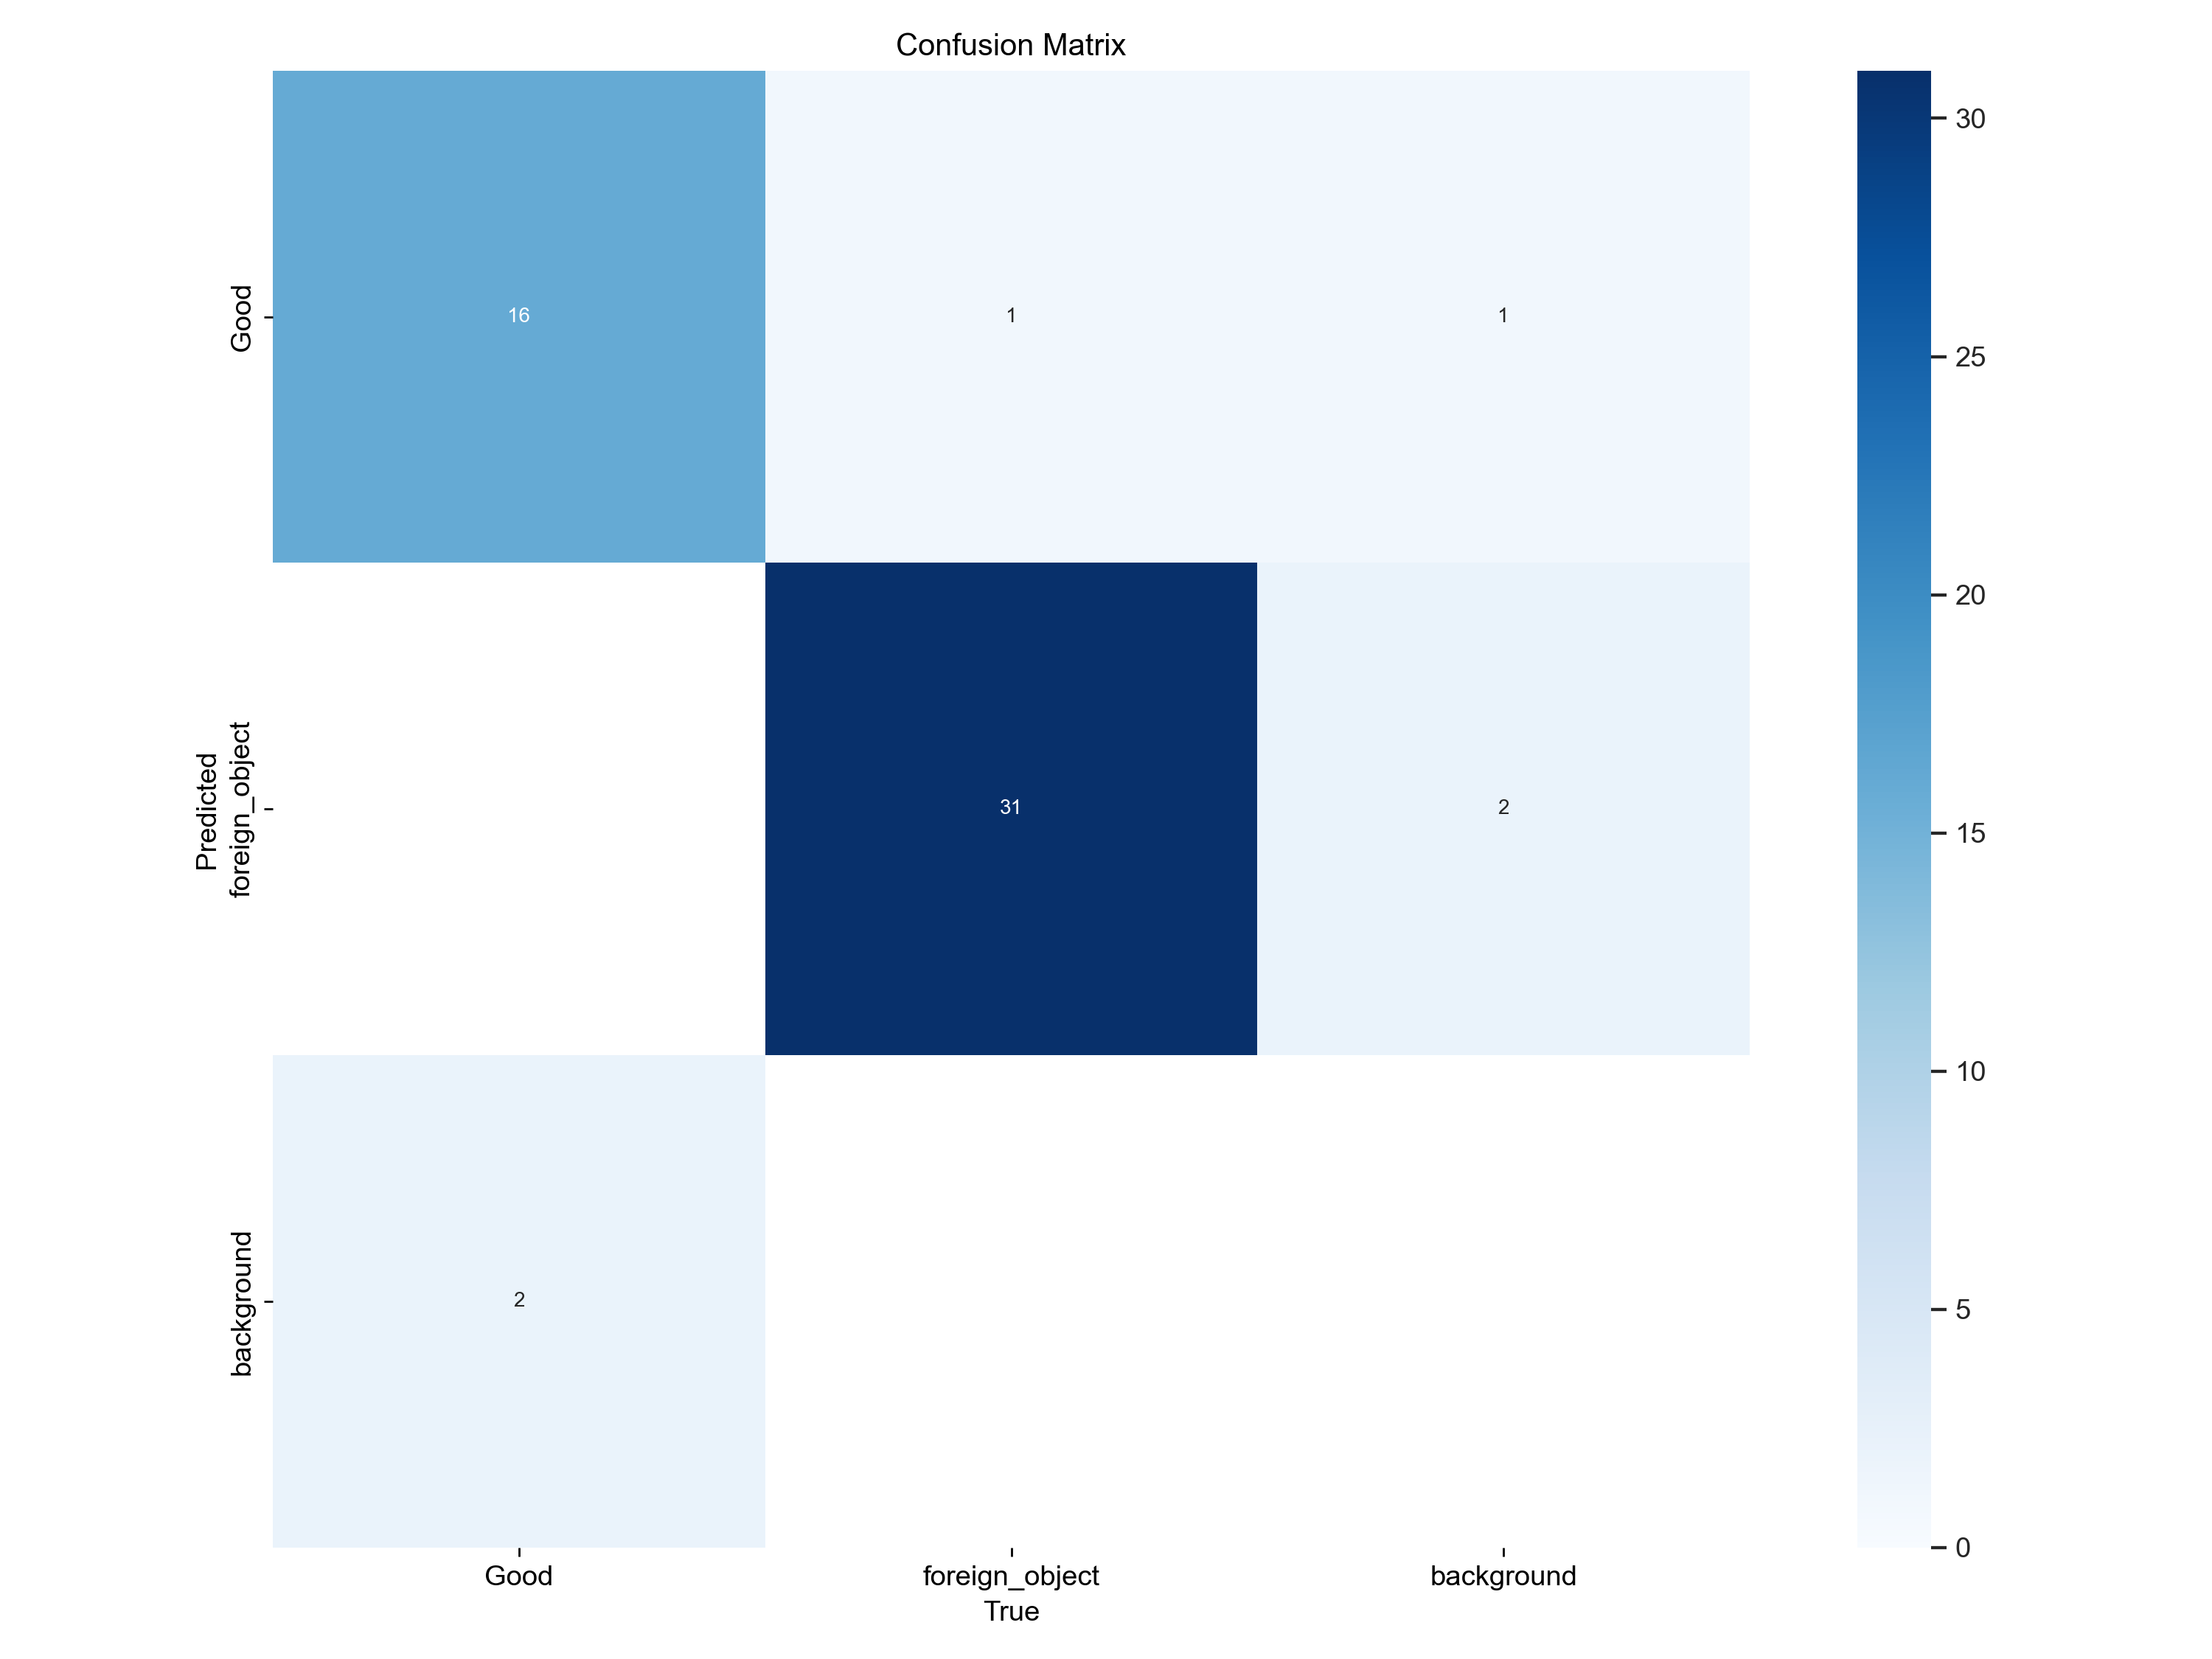

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

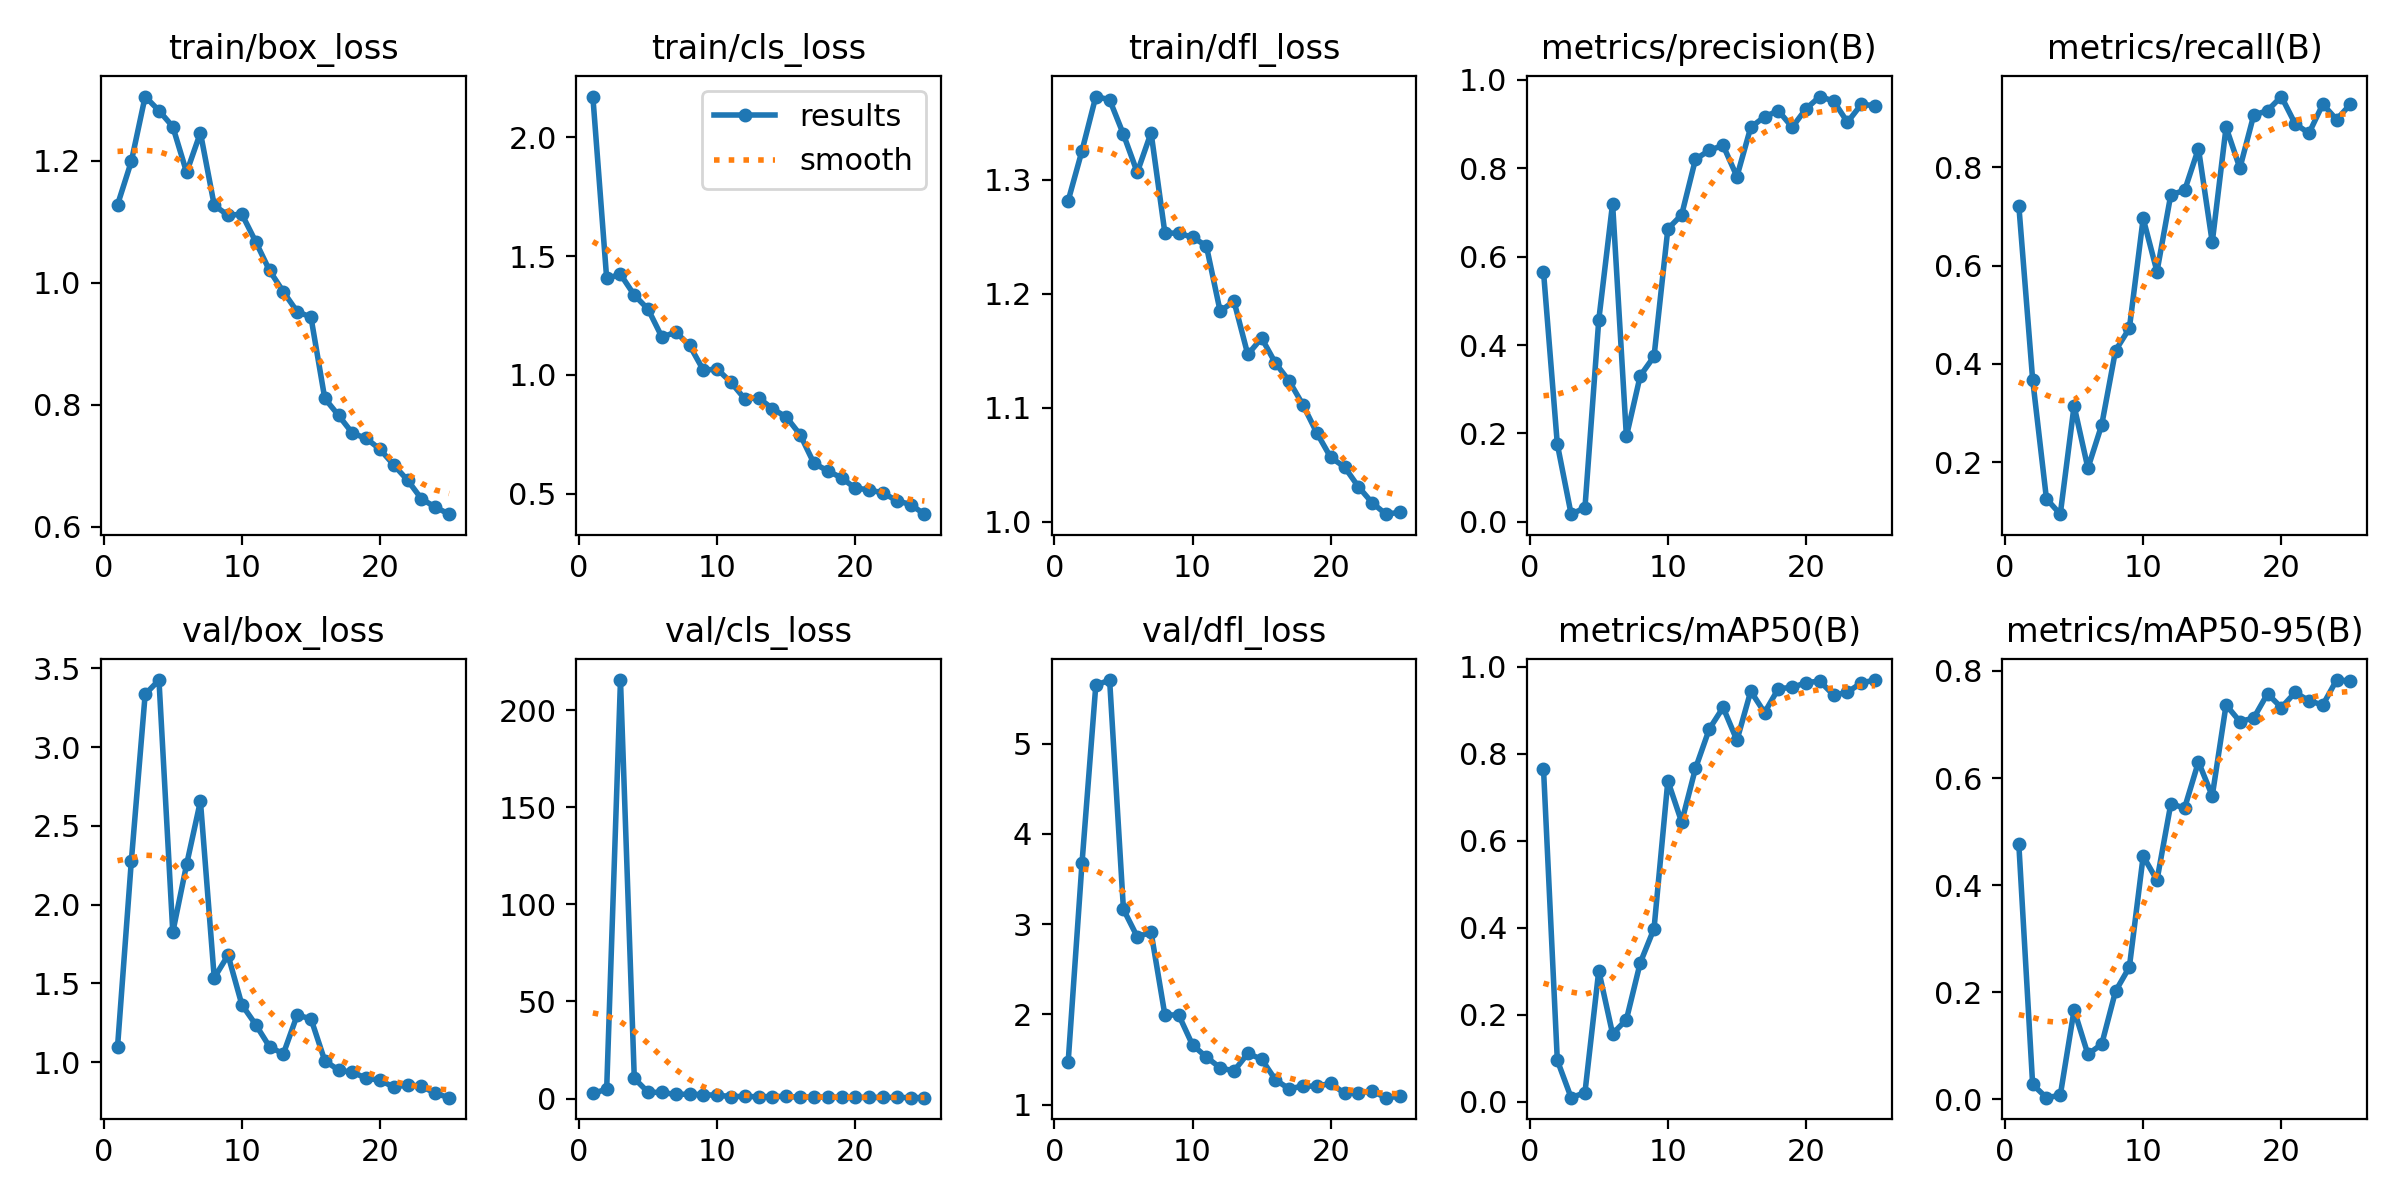

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

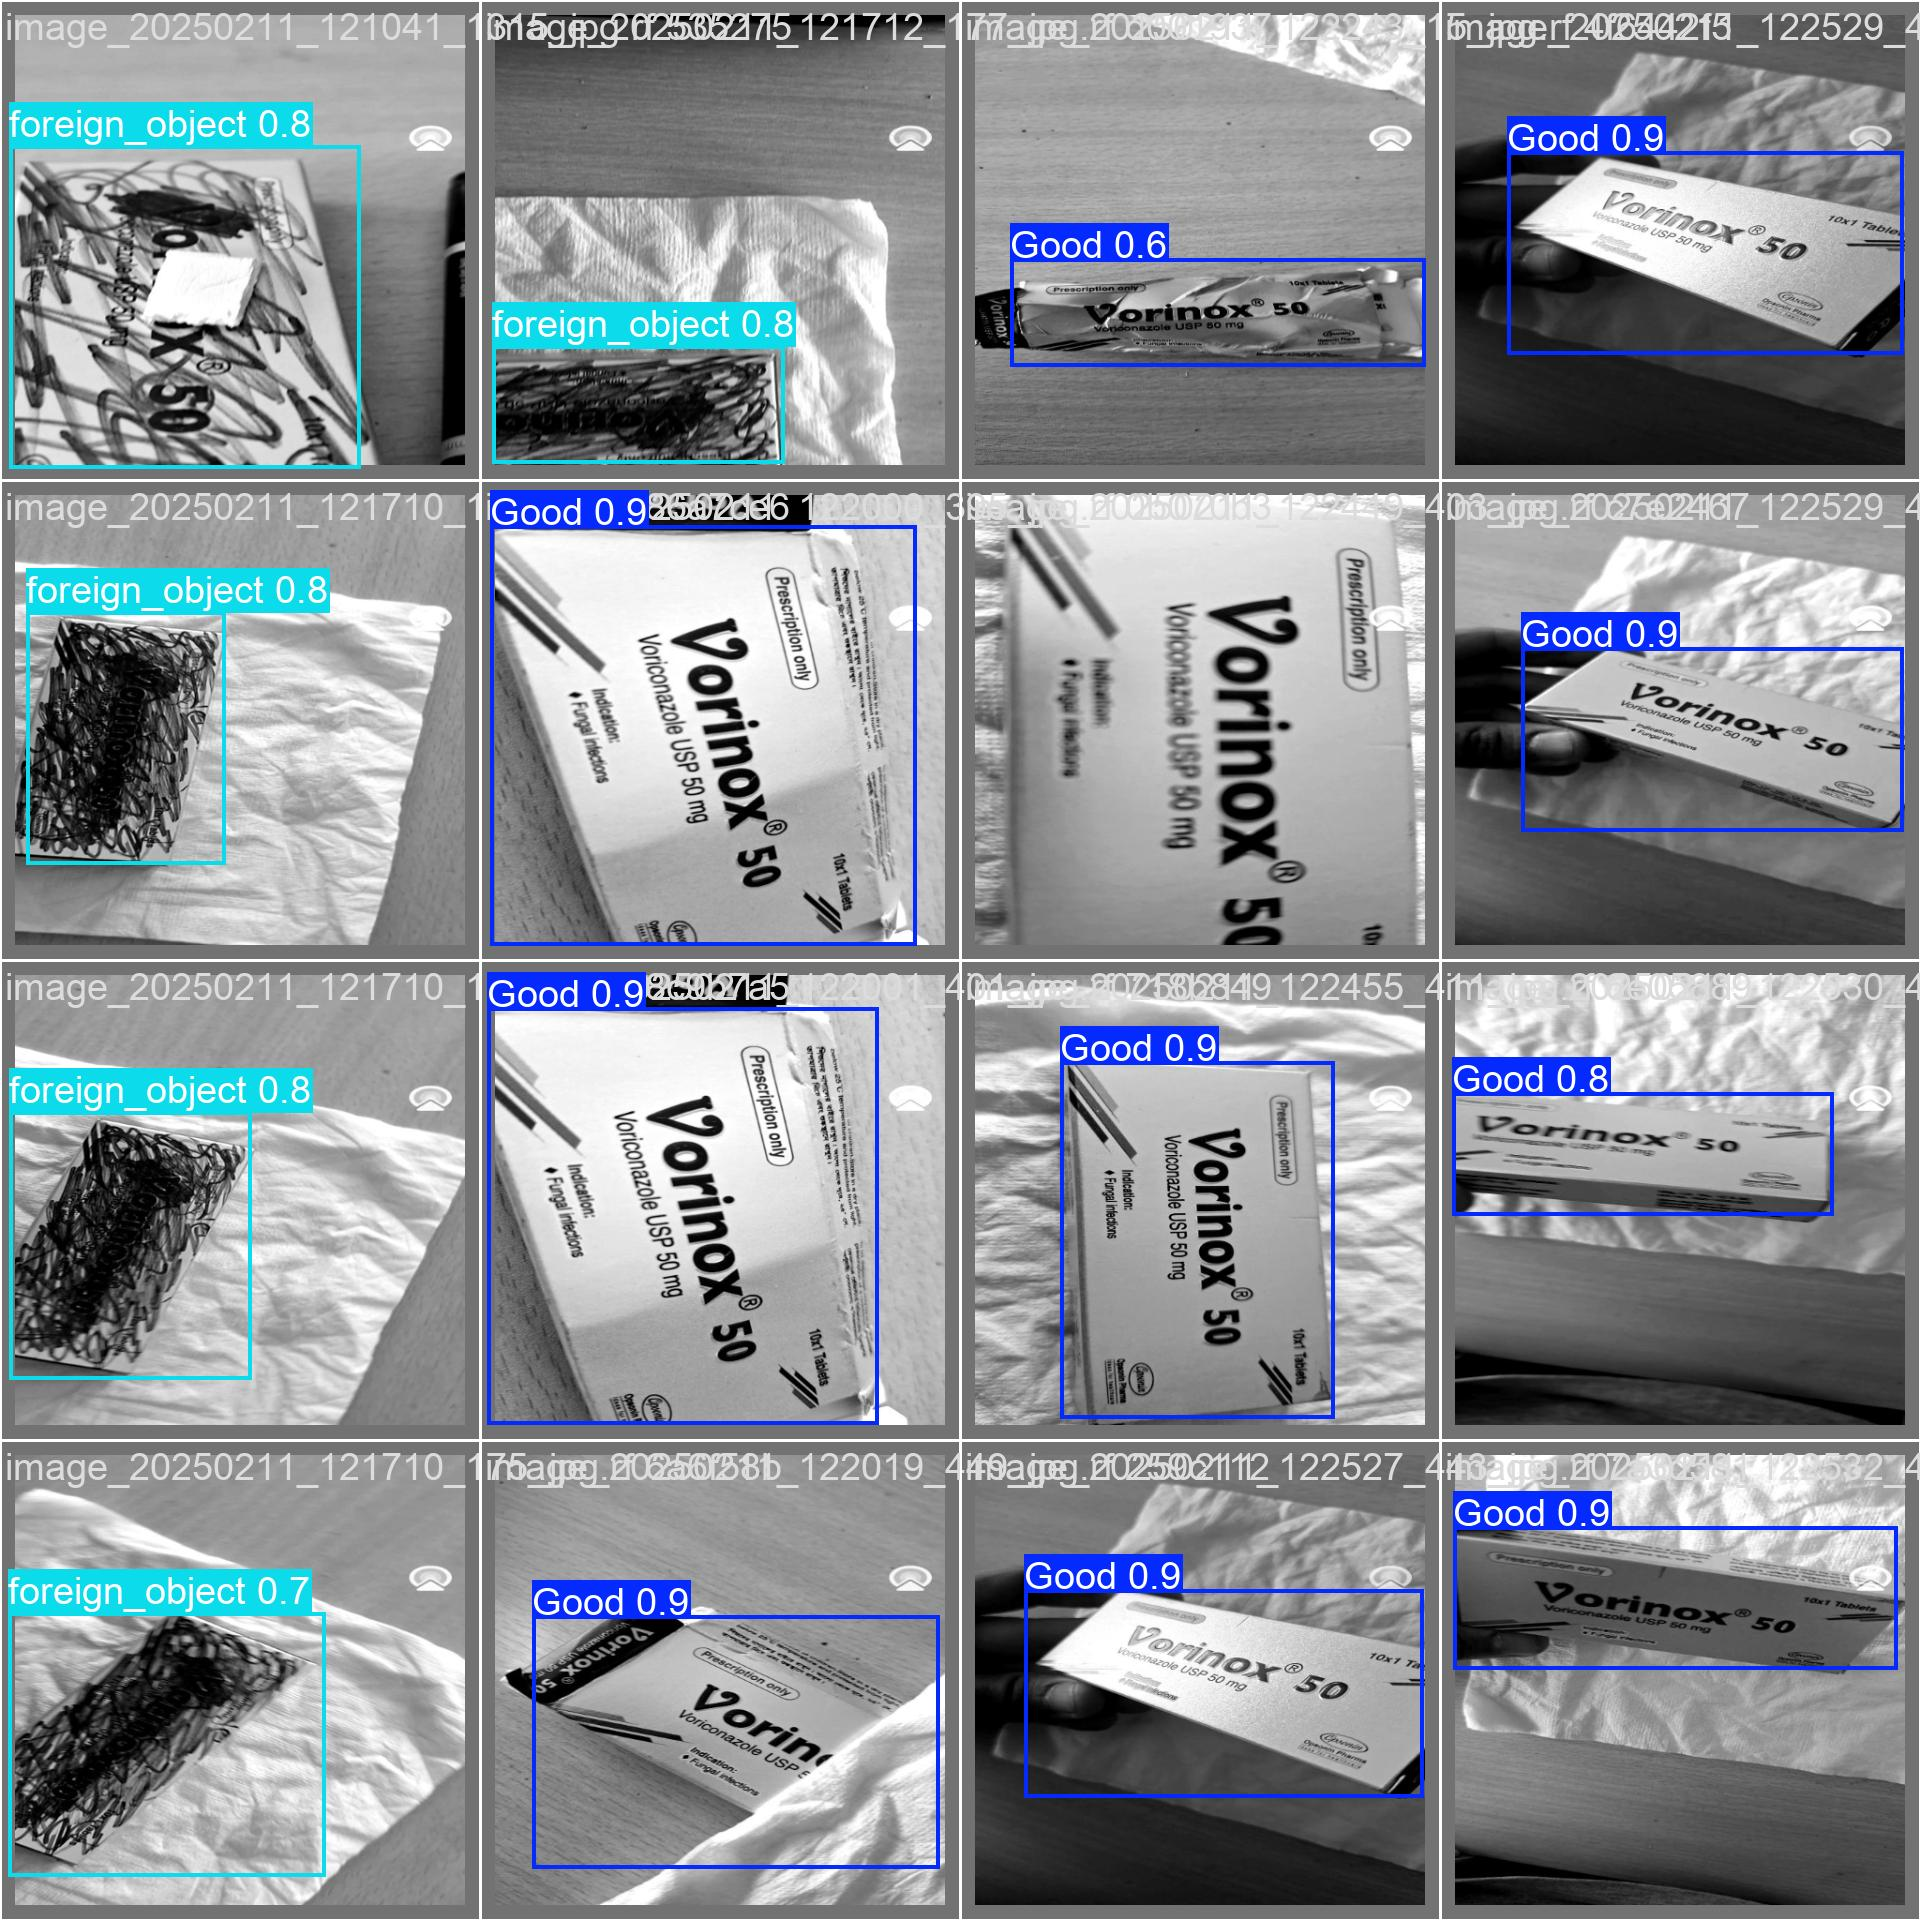

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [9]:
!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.12.8 torch-2.5.1 CPU (Apple M4 Pro)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /Users/rahi/Code/hobby/nimra/datasets/Product-Printing-Fault-Detec
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         50         50      0.944      0.898      0.963      0.783
                  Good         18         18      0.898      0.889      0.937      0.751
        foreign_object         32         32       0.99      0.906      0.989      0.815
Speed: 0.4ms preprocess, 166.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [10]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.12.8 torch-2.5.1 CPU (Apple M4 Pro)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/20 /Users/rahi/Code/hobby/nimra/datasets/Product-Printing-Fault-Detection-1/test/images/image_20250211_121045_1332_jpg.rf.f9937adac5f618eab8211cd6b471e6c9.jpg: 480x480 1 foreign_object, 37.5ms
image 2/20 /Users/rahi/Code/hobby/nimra/datasets/Product-Printing-Fault-Detection-1/test/images/image_20250211_121047_1340_jpg.rf.5fee3c273296efdaf074c8e802e5f0cf.jpg: 480x480 1 foreign_object, 31.3ms
image 3/20 /Users/rahi/Code/hobby/nimra/datasets/Product-Printing-Fault-Detection-1/test/images/image_20250211_121101_1404_jpg.rf.b8f35e0d826ed5adff9d8eeb8598460b.jpg: 480x480 1 foreign_object, 31.2ms
image 4/20 /Users/rahi/Code/hobby/nimra/datasets/Product-Printing-Fault-Detection-1/test/images/image_20250211_121150_1516_jpg.rf.b00fb64b4f3299cd28a468da63e62a6e.jpg: 480x480 1 foreign_object, 29.8ms
image 5/20 /Users/rahi/Code/hobby/nimra/datas

**NOTE:** Let's take a look at few results.

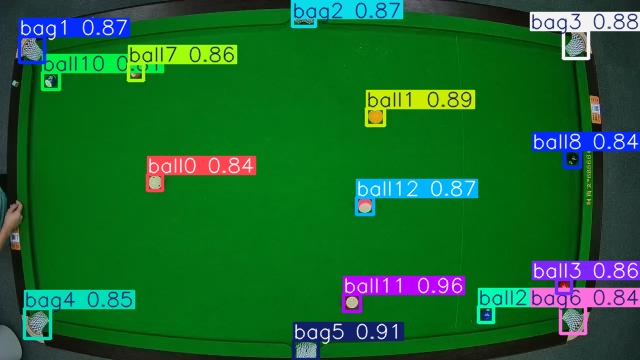

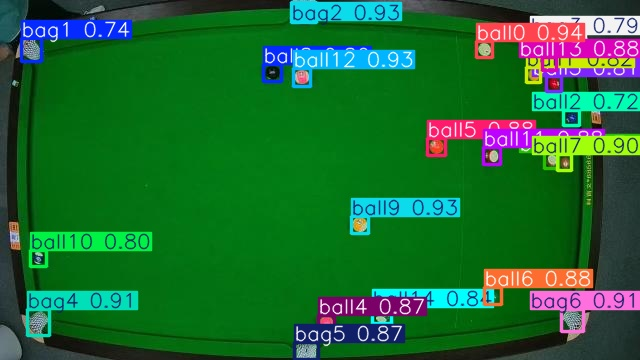

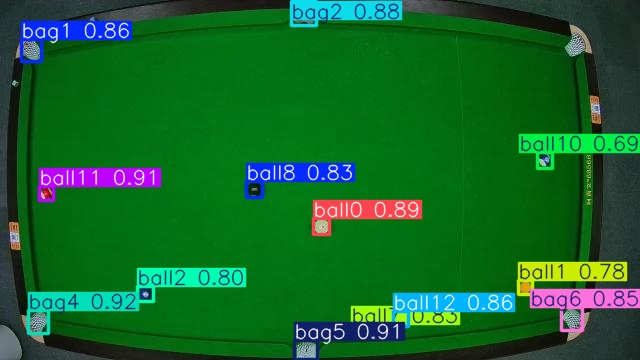

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.